# Processing A Single Exposure Image

In this tutorial, you will learn how to perform photometry on a single image. Before doing this tutorial, you should have watched the Introduction to Photometry video lecture. In this tutorial, you will 
1. Do a tutorial on displaying images
2. Read in a fits image and display it in Python
3. Calculate the background for the whole image and subtract it. 
4. Pick out the target and reference stars

==============================================

5. Put it all together: Do Aperture photometry
6. Create a cutput image around the target star

You will be using many skills you learned in the PASEA Alumni Programming Python Workshops. Skills include reading in fits files, plotting and functional programming. 

This notebook requires installing the following Python modules. This should be set up already on the google co-lab platform. 
* pip install photutils
* pip install astropy
* pip install imageio

In [7]:
# Import statements

import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# 1. Tutorial on plotting images

An image is a 2D array of numbers. You can display a 2D array of numbers as an image using matplotlib.pyplot's imshow. 

The example below has pixel values mostly around 1-3, but one pixel value (lower left) is 1000. When you display it, the 1000 pixel will be displayed as white and because the rest of the pixels are so close together in value, they will all appear black. This is because the range between 1 and 1000 is evenly assigned colours black to white in an even gradient. 

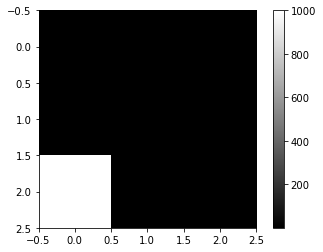

In [8]:
simple_image = [[1.,2.,1.3],
                [1.9,2.3,1.8],
                [1000,2.1,1.4]]
plt.imshow(simple_image, cmap='gray')
# To see what color represents what value, add a colorbar: 
plt.colorbar()

What if we want to see the variation in pixel value of the pixels with values 1-3? We can ask imshow to plot all pixels brighter than 3 as white and all pixels fainter than 1 as black. This way, only the pixel values between 1 and 3 will need to be assigned colours black to white with an even gradient.  

`plt.colorbar` adds the colorbar on the right hand side.

Notice in the image shown below, the colorbar now only shows colors for numbers between 1 and 3. 
Any value smaller than one will be black, any value larger than 3 will be white.
E.g. Notice below the top left pixel value is 1, and it is black and the bottom left pixel value is 1000 and it is white. 

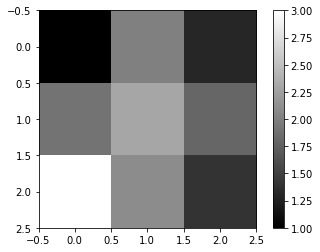

In [9]:
simple_image = [[1.,  2., 1.3],
                [1.9, 2.3,1.8],
                [1000,2.1,1.4]]

plt.imshow(simple_image,vmin=1, vmax=3, cmap='gray')
plt.colorbar()

## Exercises

Try plotting the below image and setting your own vmax and vmin so that you see the following displayed for the simple_image defined below.
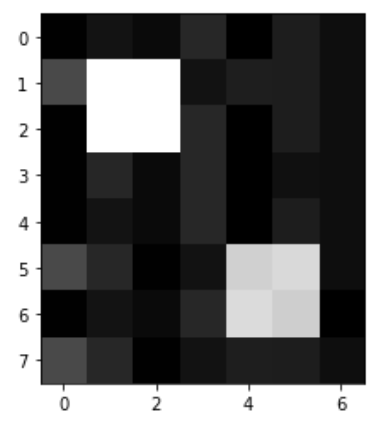

Also try plotting the image with a different cmap, which defines what the color to display the image. 

In [10]:
# You can do your exercise in this cell, as well as make extra cells. 

simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

# Exercise: display your image so it looks like the above

In [11]:
# You can do your exercise in this cell, as well as make extra cells. 

simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

# Exercise: display your image in a different color

There is a function that helps you set reasonable vmin and vmax values for any input image. Here is an exmaple of how to use it. 

In [12]:
simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

interval = ZScaleInterval()
vmin     = interval.get_limits(simple_image)[0]
vmax     = interval.get_limits(simple_image)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

# Exercise: Use this automatically determined vmin and vmax to display your image. 

vmin:  0.9
vmax:  8.613069828722004


# 2. Read in a fits image and display it in Python
First Define where the image you will analyse is located. 

In [13]:
# Set path to file
file_input   = '../../../Data/Target_A/B/coj0m403-kb97-20191006-0058-e91.fits.fz'
mypath       = './' 

In [ ]:
############################# Replace above cell with wget ##############################
# Link to the above fits file:
# https://cloudstor.aarnet.edu.au/plus/s/B5PbMH6PjL86HGa

Then open the fits file for the single image and display it. Notice in the `plt.imshow` line below, we set `origin='lower'`. This puts 0,0 in the bottom left instead of 0,0 in the top left as is the default (you can see in the above that 0,0 is in the top left.

vmin:  235.64383
vmax:  415.25894


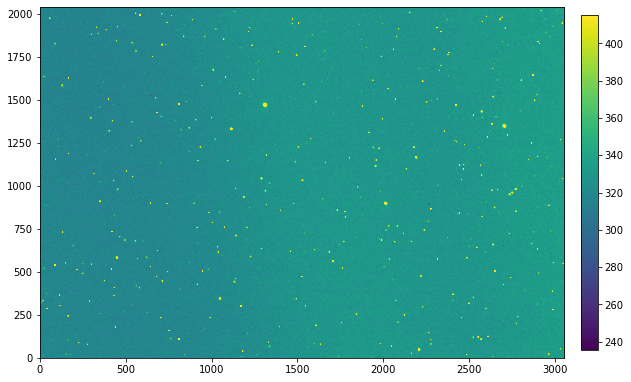

In [14]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok

# Read in the data and the fits file header information
sci_data, sci_header   = fits.getdata(file_input,header=True)

# Get the best vmin and vmax to visualize the image
# See why these two values were picked using ds9. 
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_data)[0]
vmax     = interval.get_limits(sci_data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

figure = plt.figure(figsize=(10,22))     # This sets the figure (image) size, and is larger than default.
im = plt.imshow(sci_data, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(im,fraction=0.03, pad=0.03) # This sets the colorbar size and position. 

# 3. Calculate the background for the whole image and subtract it. 

To be able to measure the brightness of stars, first the sky background must be found and subtracted. Here we will estimate the background of every pixel in the image, then subtract it from the image to get a background subtracted image with which we can measure the brightness of stars. To estimate the background we will use a software called Source Extractor. 

In [15]:
# Sigma clip bright obvious things to avoid biasing the background estimate
sigma_clip    = SigmaClip(sigma=3.) 

# Apply the SExtractor algorithm to our estimation
bkg_estimator = SExtractorBackground() 
bkg           = Background2D(   sci_data, (50, 50),
                                filter_size=(3, 3),
                                sigma_clip=sigma_clip,
                                bkg_estimator=bkg_estimator )

# Now let's subtract the background from the data
# The background that Source Extractor calculated is stored in the variable bkg.background. 
sci_bkg = sci_data - bkg.background

## Exercise

Display the background image found above, i.e. bkg.background. You can use what you learned about displaying images in the "1. Tutorial on plotting images" above. Just like the fits image displayed above, put the origin of your image in the lower left. 

vmin:  315.2470098222169
vmax:  335.9592823316951


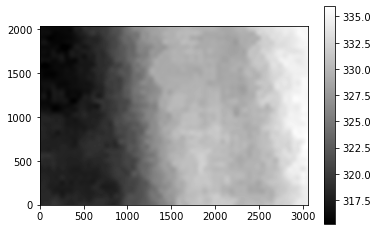

In [16]:
interval = ZScaleInterval()
vmin = interval.get_limits(bkg.background)[0]
vmax = interval.get_limits(bkg.background)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

#figure = plt.figure(figsize=(12,24))
im = plt.imshow(bkg.background, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.colorbar()
#plt.colorbar(im,fraction=0.03, pad=0.03)

## Exercise
Show the background subtracted image and see what it looks like. Can you tell that it's been background subtracted? Does it look different to the original image?

In [17]:
# Show the background subtracted image 

# 4. Pick out the target and reference stars

As you learned in the Introduction to Photometry tutorial, to do photometry, you need to determine a zeropoint that needs to be added to the uncalibrated magnitude of stars in your image to turn them into calibrated magnitudes. Calibrated magnitudes are useful as they directly relate to physical flux units (where flux is measured in energy per second per collecting area). 

E.g. 
1. You add up the pixel values in background subtracted image of the reference star, let this be counts_ccd_ref = 10,000
2. you turn this into uncalibrated magnitude, m_uncalibrated_ref = -2.5*log10(counts_ccd_ref) = -10
3. Since this is a reference star, others have measured the calibrated magnitude, let's say it is m_calibrated_ref = 17
4. then your zerpoint, zp = m_calibrated_ref - m_uncalibrated_ref = 17 - (-10) = 27. 
5. You can now find the calibrated magnitude of any star that you count up the pixel values for. 
6. Say counts_ccd_MYSTAR = 1000
7. m_uncalibrated_MYSTAR = -2.5*log10(counts_ccd_MYSTAR) = -7.5
8. m_calibrated_MYSTAR = m_uncalibrated_MYSTAR + zp = -7.5 + 27 = 19.5

Below, the instructors have chosen a random star in the image that is not saturaed. Our goal now is to get the calibrated magnitude of this target star.

We will use a series of reference stars to calculate the zeropoint (find zeropoints for all of them and use the median as our zeropoint). The reference stars were identified to be bright stars that are not saturated. We note their RAs and DECs below, and also find them in an online reference catalog to find their calibrated mag in the right filter. We have already done this step for you. 

In [18]:
########################### INSERT BIT ON HOW TO ID REFERENCE STARS ###########################

In [19]:
# Target star RA and DEC. This is a random unsaturated star. 
# We are pretending this is our target. We want to try and find the magnitude of this star.
target_RA  = 299.18555
target_DEC = -1.0214

# Ref stars RAs and DECs. These are bright but not saturated. 
# Their mag_calibrated_ref was found by cross matching with the APASS catalog.
# You can download the APASS catalog from here: 
# https://www.aavso.org/apass-dr10-download
# To download, choose RA and DEC ranges that overlap with your image and not the entire catalog, which is large.
ref_ra             = [299.11433, 299.0763, 299.20659, 299.23568,299.25526]
ref_dec            = [-0.84994178, -0.94528461, -1.1268563, -1.2084083,-0.98725623]
mag_calibrated_ref = [12.2291, 12.372, 12.119,9.939,9.246]

## Let's visualise where on the image are our target and reference stars.
To do this, we have to mark circles where the target and reference stars are. We have to know the x,y position in pixel coordinates for this image, and not just the RA and DEC. To get the x,y pixel coordinates, we use the World Coordinate System information in the header of the fits image to convert RA/DEC to x,y pixels. 

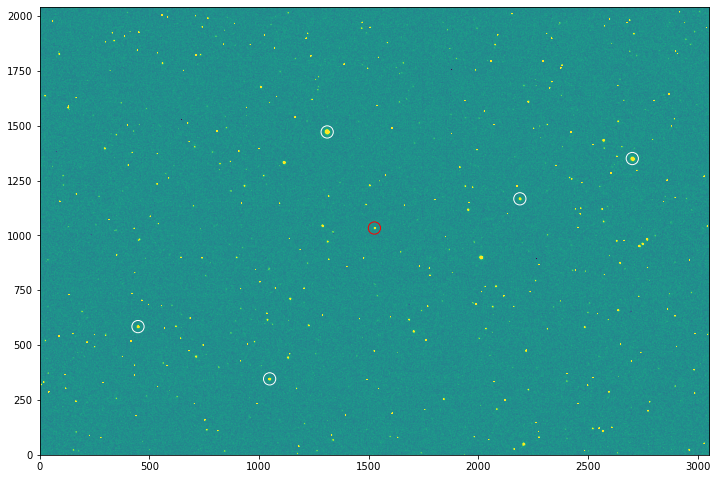

In [20]:
# Plot the whole image (background subtracted version) with the reference star and target star marked to see if it all looks ok

# Read in the data and the fits file header information
sci_data, sci_header   = fits.getdata(file_input,header=True)

# Get the World Coordinate System (WCS) from the fits header. 
w                            = wcs.WCS(sci_header)

# Convert RA and DEC to x,y pixel coordinate for ref and target stars using the WCS. 
xcoord_ref, ycoord_ref       = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([target_RA],[target_DEC],1)

# Get the best vmin and vmax to visualize the image
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_bkg)[0]
vmax     = interval.get_limits(sci_bkg)[1]

# Plot the figure
figure = plt.figure(figsize=(12,24))
plt.imshow(sci_bkg, vmin=vmin, vmax=vmax, origin='lower')

# Mark with a red circle the target stars. 
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

# Mark with white circles the reference stars. 
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')

# ====================================
# 5. Put it all together: Do Aperture Photometry

This is where the photometry actually happens! 

*Important Note: All the steps are here from start to end. I.e. yes we learned about lots of things above such as background subtraction above, but here we do it again from start to end.*

## A useful function
A function that outputs the uncalibrated magnitude of a source, and its error. The inputs to the function are the background subtracted science image "data", the fits header "hdr", the error image "error" that you get from determining the background and the RA "ra" and DEC "dec" of the object you want to measure photometry to. 

You will be using this function to do photometry. 

In [21]:
def do_phot_get_mag(data,hdr,err,ra,dec):

    # Get the WCS from the input header or "hdr"
    w         = wcs.WCS(hdr)
    
    # Calculate the x,y pixel coordinates given the RA and DEC input
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    # Get it in the required format
    positions = np.transpose((xcoords, ycoords))
    
    # Set the aperture inside which to add up the pixel values
    apertures = CircularAperture(positions, r=24.)
    # Perform the photometry given the image, the apertures and the error image. 
    phot      = aperture_photometry(data, apertures, error=err)

    # calculate the uncalibrated magnitude of the sources
    mag     = list(-2.5*np.log10(phot['aperture_sum']) )
    # calculate the error of the uncalibrated magnitudes
    mag_err = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,mag_err

### a. Open the frame and read out the data, header and time of observation

In [22]:
# Set path to file
file_input   = '../../../Data/Target_A/B/coj0m403-kb97-20191006-0058-e91.fits.fz'
mypath       = './' 

# Read in file
sci_data, sci_header   = fits.getdata(file_input,header=True)

# The "header" of fits files contains a lot of information on the image.

# Grab the time of observation of this image.
mjd      = sci_header['MJD-OBS']
datetime = sci_header['DATE']

# print RA and DEC in header, which tells you where the telescope was pointing when this image was taken.
print('RA:',sci_header['RA'])
print('DEC:',sci_header['DEC'])

RA: 19:56:44.0641
DEC: -01:01:17.852


In [23]:
# print the whole header to have a look
print('\nEntire header:')
sci_header


Entire header:


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3054                                                  
NAXIS2  =                 2042                                                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
DATADICV= 'LCOGT-DIC.FITS-0.11.0' / Version number of the data dictionary       
HDRVER  = 'LCOGT-HDR-1.4.0'    / Version number of the headers                  
ORIGIN  = 'LCOGT   '           / Organization responsible for the data          
SITEID  = 'coj     '           / ID code of the Observatory site                
SITE    = 'LCOGT node at Sid

### Exercise

In [5]:
# Print the time of observation of this exposure

### b. Get the background of the image and subtract it; Calculate the error associated with the background.

Note: The error is calculated by adding the rms error of the background and the background subtracted science image together. 

In [24]:
# Background estimation:
sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
bkg = Background2D(
    sci_data.data, (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator)

# Now let's subtract the background from the data
sci_bkg = sci_data.data - bkg.background

# Define an error image that will be used when calculating photometry
effective_gain = 1.
error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

### c. For the target star and each reference star, carry out photometry. We must use the background subtracted image. This step should output an error of the photmetry measurement. 

In [25]:
# Target star RA and DEC. This is a random unsaturated star. 
# We are pretending this is our target. We want to try and find the magnitude of this star.
target_RA  = 299.18555
target_DEC = -1.0214

# Ref stars RAs and DECs. These are bright but not saturated. 
# Their mag_calibrated_ref was found by cross matching with the APASS catalog.
# You can download the APASS catalog from here: 
# https://www.aavso.org/apass-dr10-download
# To download, choose RA and DEC ranges that overlap with your image and not the entire catalog, which is large.
ref_ra             = [299.11433, 299.0763, 299.20659, 299.23568,299.25526]
ref_dec            = [-0.84994178, -0.94528461, -1.1268563, -1.2084083,-0.98725623]
mag_calibrated_ref = [12.2291, 12.372, 12.119,9.939,9.246]

# Calculate instrumental mags for each of the reference stars
mag_uncalibrated_refs,mag_uncalibrated_refs_err     = do_phot_get_mag(sci_bkg,sci_header,error,ref_ra,ref_dec)

# Do photometry on the variable target
mag_uncalibrated_target,mag_uncalibrated_target_err = do_phot_get_mag(sci_bkg,sci_header,error,target_RA,target_DEC)

### d. Find the magnitude offset between the reference stars and the catalog magnitudes (i.e. the zeropoint) and calculate the magnitude of the target star, and its error. 

In [26]:
# Calculate the zeropoint
offsets = mag_calibrated_ref - np.array(mag_uncalibrated_refs)

# Print the offset values
print('These are the offsents between m_uncalibrated_ref and m_calibrated_ref: \n',offsets)

# Calculate the zeropoint using a median function
zeropoint     = np.median(offsets)
zeropoint_err = np.std(offsets)
print(f'\nThe zeropoint and zeropoint error is: {zeropoint:.3f}, {zeropoint_err:.2f}')

These are the offsents between m_uncalibrated_ref and m_calibrated_ref: 
 [23.94164668 23.9748074  23.84377595 24.00134987 23.87568321]

The zeropoint and zeropoint error is: 23.942, 0.06


In [27]:
# Calculate the calibrated magnitude of the target star and it's error

mag_calibrated_target     = mag_uncalibrated_target[0]+zeropoint
mag_calibrated_target_err = mag_uncalibrated_target_err[0] + zeropoint_err

### Exercise

In [6]:
# Print the magnitude and magnitude error of your target.


# 6. Create a cutout image around the target star
If you have more than 1 exposure, cutouts of each exposure can be used to gether to make a gif of the star over time. 

In [28]:
# A function that outputs a small cutout of an image given a big image. 

def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

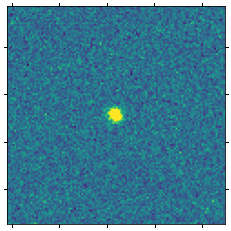

In [32]:
# Make tiny cutouts of the variable star in each frame
cutout_hdu = make_cutout(sci_bkg,sci_header,target_RA,target_DEC)

# Plot figures using these cutouts and output images
interval = ZScaleInterval()
vmin = interval.get_limits(cutout_hdu.data)[0]
vmax = interval.get_limits(cutout_hdu.data)[1]

plt.subplot(projection=wcs.WCS(cutout_hdu.header))
plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
plt.xlabel('R.A.')
plt.ylabel('Declination')

# Save the small cutout as a png, with the file name as the time of observation. 
# This can be used later to make a movie of your source
pngname = 'cutout'
plt.savefig(mypath+pngname+'.png', overwrite=True)

# Exercise

Select some other star as your target star, and calculate the calibrated magnitude of that star in this exposure.